In [1]:
import os
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np

In [42]:
sources_coordinates_file = open('sources_pixels-2000.txt', 'r')
sources_coordinates_lines = sources_coordinates_file.readlines()

In [43]:
converted_lines = []
for line in sources_coordinates_lines:
    integers = [str(int(float(num))) for num in line.split(",")]
    converted_lines.append(", ".join(integers))

In [65]:
import re
data_path = '/var/tmp/zapp_an-a/Desktop/try/sim_gray_full_dataset'
# ASSUMING WE ARE DOING BINARY CLASSIFICATION
def load_data():
    # let's put directly images inside these arrays and not only image paths
    x_train = []
    y_train_loc = []
    x_test = []
    y_test_loc = []

    train_bkg_count = 0
    train_src_count = 0

    for img_name in os.listdir(data_path):
        img_full_path = data_path + '/' + img_name
        #print(img_full_path)
        image = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.pyrDown(image)
        image = cv2.pyrDown(image)
        img_index = int(re.findall('\d+', img_name )[0])
        source_x = int(converted_lines[img_index].split(",")[1])
        source_y = int(converted_lines[img_index].split(",")[2])
        source_coordinates = (source_x, source_y)
        
        if train_src_count < 1700:
            x_train.append(image)
            y_train_loc.append(source_coordinates)
            train_src_count += 1
        else: # append in test set
            x_test.append(image)
            y_test_loc.append(source_coordinates)
            train_src_count += 1

    x_train = np.array(x_train)
    y_train_loc = np.array(y_train_loc)
    x_test = np.array(x_test)
    y_test_loc = np.array(y_test_loc)
    
    #return (x_train, y_train), (x_test, y_test)
    return (x_train, y_train_loc), (x_test, y_test_loc)

In [82]:
#(x_train, y_train), (x_test, y_test) = load_data()
(x_train, y_train_loc), (x_test, y_test_loc) = load_data()

In [85]:
y_train_loc = y_train_loc / 4
y_test_loc = y_test_loc / 4
print(x_train.shape)
print(y_train_loc.shape)
print(x_test.shape)
print(y_test_loc.shape)

(1700, 125, 125)
(1700, 2)
(300, 125, 125)
(300, 2)


In [86]:
print(y_train_loc)

[[50.25 35.  ]
 [26.   46.  ]
 [44.25 64.5 ]
 ...
 [61.25 32.5 ]
 [43.5  53.5 ]
 [65.25 26.  ]]


In [87]:
x_train = x_train / 255
x_test = x_test / 255

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the input shape based on your image size
input_shape = (125, 125, 1)

# Define the model architecture with regularization
def create_model():
    input_layer = Input(shape=input_shape)
    
    # Convolutional layers with L2 regularization
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    maxpool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(maxpool1)
    maxpool2 = MaxPooling2D((2, 2))(conv2)
    
    # Flatten layer
    flatten = Flatten()(maxpool2)
    
    # Dense layers with dropout
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
    dropout1 = Dropout(0.5)(dense1)  # Dropout layer with 50% dropout rate
    output_layer = Dense(2)(dropout1)  # Output layer with 2 neurons for x and y coordinates
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [89]:
from tensorflow.keras.callbacks import EarlyStopping
model = create_model()

# Create EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [104]:

# Train the model using data augmentation
batch_size = 16
epochs = 50

history = model.fit(
    x_train, y_train_loc,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
)

#tot epochs = 83

Epoch 1/50
96/96 [==============================] - 8s 83ms/step - loss: 176.4080 - accuracy: 0.8863 - val_loss: 156.5021 - val_accuracy: 0.9118
Epoch 2/50
96/96 [==============================] - 8s 87ms/step - loss: 188.0654 - accuracy: 0.8869 - val_loss: 155.7099 - val_accuracy: 0.9294
Epoch 3/50
96/96 [==============================] - 8s 85ms/step - loss: 177.6231 - accuracy: 0.9105 - val_loss: 155.0871 - val_accuracy: 0.9059
Epoch 4/50
96/96 [==============================] - 8s 85ms/step - loss: 179.8728 - accuracy: 0.8974 - val_loss: 160.2266 - val_accuracy: 0.9059
Epoch 5/50
96/96 [==============================] - 7s 78ms/step - loss: 194.6648 - accuracy: 0.8961 - val_loss: 160.3731 - val_accuracy: 0.9176
Epoch 6/50
96/96 [==============================] - 8s 83ms/step - loss: 186.8768 - accuracy: 0.8987 - val_loss: 154.1506 - val_accuracy: 0.9118
Epoch 7/50
96/96 [==============================] - 8s 87ms/step - loss: 180.6482 - accuracy: 0.8948 - val_loss: 161.5760 - val_ac

1/1 [==============================] - 0s 14ms/step
[88.83723  58.563675]


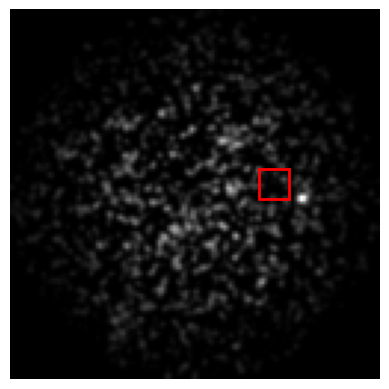

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming you have the model predictions for a test image
test_image_index = 9# Change this to the index of the test image you want to visualize
test_image = x_test[test_image_index]
coord_predictions = model.predict(np.expand_dims(test_image, axis=0))


# Extract predicted coordinates
predicted_coords = coord_predictions[0]
print(predicted_coords)

# Display the test image
plt.imshow(test_image, cmap='gray')
plt.axis('off')

# Add bounding box if source is predicted

x, y = predicted_coords  # Adjust coordinates according to your format
width = height = 10  # Adjust these values according to your desired box size
rect = patches.Rectangle((x - width/2, y - height/2), width, height, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()
